In [1]:
!pip install pandas

     |████████████████████████████████| 10.0 MB 2.3 MB/s eta 0:00:01    |██████████████████████████▎     | 8.2 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 509 kB 25.2 MB/s eta 0:00:01


In [2]:
!pip install matplotlib

     |████████████████████████████████| 12.4 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 7.1 MB/s  eta 0:00:01
     |████████████████████████████████| 67 kB 6.0 MB/s  eta 0:00:01


In [3]:
!pip install sklearn

     |████████████████████████████████| 7.1 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 27.9 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=7c7d23e076955be6d11defe39217e6d6878424d1b635d498a9a99de89a89e699
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn


In [4]:
!pip install joblib

In [5]:
!pip install statsmodels

     |████████████████████████████████| 8.7 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 18.6 MB/s eta 0:00:01


In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error 
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline 
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', 9999)
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

##Variables: <br>
df_train_orig --> hourly freq <br>
df_test_orig -->  hourly freq <br>
train        -->  daily freq <br>
valid        -->  daily freq <br>


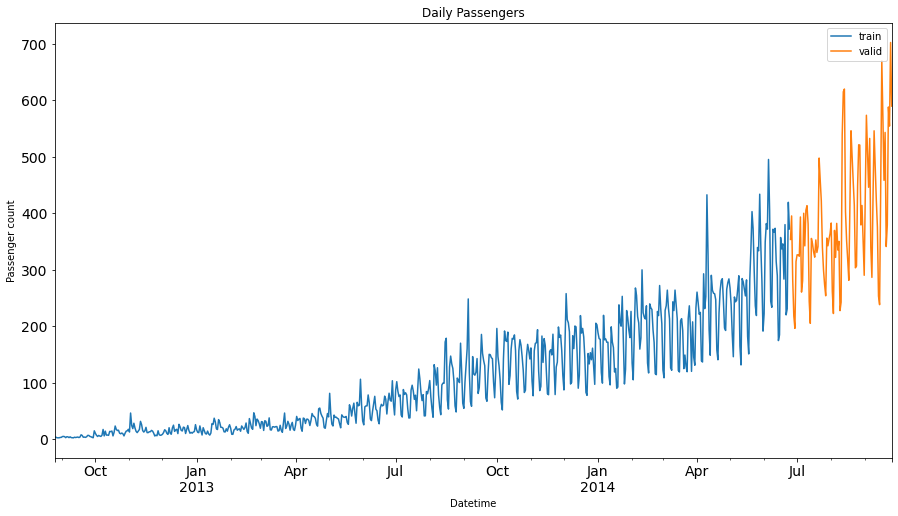

In [7]:
df_train_orig=pd.read_csv('Train_SU63ISt.csv')
df_test_orig=pd.read_csv('Test_0qrQsBZ.csv')
train=df_train_orig.copy()
test=df_test_orig.copy()
df_train_orig.Datetime = pd.to_datetime(df_train_orig.Datetime, format='%d-%m-%Y %H:%M')
df_test_orig.Datetime = pd.to_datetime(df_test_orig.Datetime, format='%d-%m-%Y %H:%M')
train.Datetime = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test.Datetime = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
for i in (df_train_orig, df_test_orig, train, test):
  i['year']=i.Datetime.dt.year 
  i['month']=i.Datetime.dt.month 
  i['day']=i.Datetime.dt.day
  i['hour']=i.Datetime.dt.hour
  i['weekday']=i.Datetime.dt.weekday
  i.index=i.Datetime
  i.drop('ID', axis=1, inplace=True)
	
train_valid_daily = train.resample('D').mean()

valid=train_valid_daily.loc['2014-06-25':'2014-09-25']
train=train_valid_daily.loc['2012-08-25':'2014-06-24']

train.Count.plot(figsize=(15,8), title= 'Daily Passengers', fontsize=14, label='train') 
valid.Count.plot(figsize=(15,8), title= 'Daily Passengers', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()

def rmse(validCount, predCount):
  return sqrt(mean_squared_error(validCount, predCount)) 

#Grid-Search SARIMAX

In [9]:
def evaluate_sarima_model(train, test, arima_order, seasonalOrder):
    try:
        # no need to calcuate if order as well as seasonal differencing is 0
        if (arima_order[1]+seasonalOrder[1])==0:
          print(f"##### Skipped modelling with: {arima_order}, {seasonalOrder} --> Both d & D are zeroes\n")
          # return a high value of RMSE so that it sits at the bottom of the list when sorted
          return 999999999, arima_order, seasonalOrder
          
        y_hat = test.copy() 
        model = SARIMAX(train.Count, order=arima_order, seasonal_order=seasonalOrder)
        model_fit = model.fit()
        predict = model_fit.predict(start="2014-6-25", end="2014-9-25", dynamic=True)
        y_hat['model_prediction']=predict

        error = rmse(test.Count, y_hat.model_prediction)
        print(f"> Model: {error}, {arima_order}, {seasonalOrder}\n")
        return error, arima_order, seasonalOrder
    except Exception as e:
        # in case of convergence errors, non-invertible errors, etc.
        print(f"##### Skipped modelling with: {arima_order}, {seasonalOrder}\n")
        print(e)
        return 999999999, arima_order, seasonalOrder

def evaluate_models_parallely(train, test, p_values, d_values, q_values, P_values, D_values, Q_values, m_values):
    # utilize aall available cores using n_jobs = cpu_count()
    executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing') 

    scor = []
    try:
      # call our function in a parallel manner
      tasks = (delayed(evaluate_sarima_model)(train, test, (p,d,q), (P,D,Q,m)) for m in m_values for Q in Q_values for D in D_values for P in P_values for q in q_values for d in d_values for p in p_values)  
      results = executor(tasks)

      scor.append(results)
    except Exception as e:
      print('Fatal Error....')
      print(e)

    return scor

In [10]:
# specify the range of values we want ot try for the different hyperprameters
p_values = np.arange(0, 2)
d_values = np.arange(1, 2)
q_values = np.arange(1, 4)
P_values = np.arange(0, 2)
D_values = np.arange(1, 2)
Q_values = np.arange(0, 3)
m_values = np.arange(7, 8)

# total combinations being tried: 2*1*3*2*1*3*1 = 36

scor=evaluate_models_parallely(train, valid, p_values, d_values, q_values, P_values, D_values, Q_values, m_values)

scores=[]
for tup_list in scor:
    for tup in tup_list:
        scores.append(tup)

# sort the results on basis of RMSE scores (ascending)
scores.sort(key=lambda x: x[0])

print('\nTop 5 SARIMA params with minimum RMSEs:\n')
for x in scores[:5]:
  print(f'RMSE={x[0]}  order={x[1]}  seasonal_order={x[2]}\n')

print("DONE!")

> Model: 275.68408270794237, (0, 1, 1), (0, 1, 0, 7)

> Model: 71.08949276392701, (0, 1, 1), (1, 1, 0, 7)

> Model: 92.83609662564469, (0, 1, 2), (0, 1, 0, 7)

> Model: 93.77406603885643, (0, 1, 3), (0, 1, 0, 7)

> Model: 92.75607295858704, (1, 1, 1), (0, 1, 0, 7)

> Model: 69.84078649014194, (0, 1, 1), (0, 1, 1, 7)

> Model: 69.91828882830511, (0, 1, 1), (1, 1, 1, 7)

> Model: 68.80485512533652, (0, 1, 2), (0, 1, 1, 7)

> Model: 68.32526787258014, (1, 1, 1), (0, 1, 1, 7)

> Model: 85.74365833150009, (0, 1, 2), (1, 1, 0, 7)

> Model: 69.92394751247473, (0, 1, 1), (0, 1, 2, 7)

> Model: 69.14344787699119, (1, 1, 1), (1, 1, 1, 7)

> Model: 88.59293110751274, (1, 1, 1), (1, 1, 0, 7)

> Model: 93.72639518905045, (1, 1, 2), (0, 1, 0, 7)

> Model: 68.98011935799217, (0, 1, 2), (1, 1, 1, 7)

> Model: 97.67765374788985, (1, 1, 3), (0, 1, 0, 7)

> Model: 69.15278673977954, (1, 1, 1), (0, 1, 2, 7)

> Model: 68.29368659667703, (1, 1, 2), (0, 1, 1, 7)

> Model: 69.00612839727155, (1, 1, 2), (1, 1,

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


> Model: 69.14419179422846, (1, 1, 3), (0, 1, 2, 7)

> Model: 68.86669101418, (0, 1, 3), (1, 1, 2, 7)


Top 5 SARIMA params with minimum RMSEs:

RMSE=68.26915300691408  order=(0, 1, 1)  seasonal_order=(1, 1, 2, 7)

RMSE=68.29368659667703  order=(1, 1, 2)  seasonal_order=(0, 1, 1, 7)

RMSE=68.32526787258014  order=(1, 1, 1)  seasonal_order=(0, 1, 1, 7)

RMSE=68.49311364217178  order=(0, 1, 3)  seasonal_order=(0, 1, 1, 7)

RMSE=68.79892795433442  order=(1, 1, 3)  seasonal_order=(0, 1, 1, 7)

DONE!
